# The Intelligent Investor vs Mr.Market
A case study in validating a Security's Share Price based on fundamental data.

##Case Study - TDG
The security to analyze, along with the date ranges for analysis are defined. A long, and short term period for analysis is defined to optimize computational resources during early research and data exploration.

In [1]:
# Define Global Vairables
stock_symbol = 'TDG'
asset = symbols(stock_symbol)
analysis_start = '2013-01-01'
analysis_start_short = '2017-01-01'
analysis_end = '2018-01-01'

In [2]:
# Pipeline imports
from quantopian.pipeline.filters import StaticAssets
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.research import prices, returns, symbols

# Fundamental & Technical Data
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.psychsignal import stocktwits, twitter_withretweets

# Computing library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

##Pricing
First, historic pricing data is imported and visualized based on the long-term period defined above.

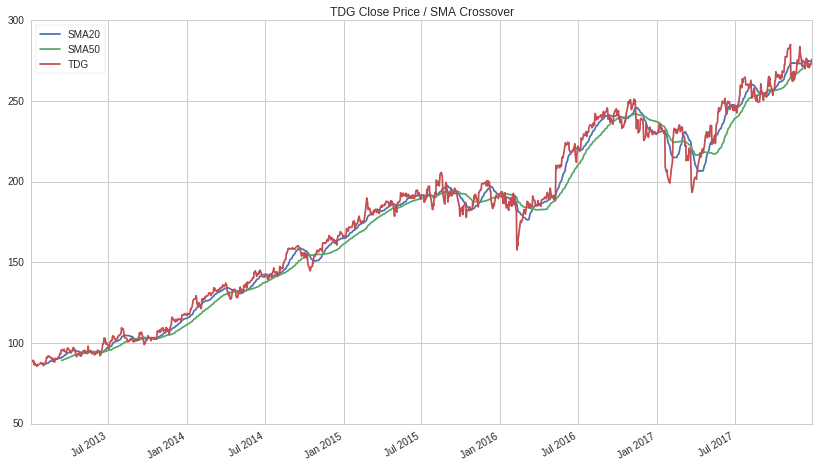

In [3]:
# Query historical pricing data for TDG
tdg_close = prices(
    assets = asset,
    start = analysis_start,
    end = analysis_end,)

# Compute 20 and 50 day moving averages on pricing data
tdg_sma20 = tdg_close.rolling(20).mean()
tdg_sma50 = tdg_close.rolling(50).mean()

# Combine results into a pandas DataFrame and plot
tdg_pricing_dataframe = pd.DataFrame({   
                        stock_symbol: tdg_close,
                        'SMA20': tdg_sma20,
                        'SMA50': tdg_sma50})

tdg_pricing_dataframe.plot(title='TDG Close Price / SMA Crossover');

## Returns
Next, daily returns are imported for the same time period.

In [73]:
# Query returns data for TDG
tdg_returns = returns(
    assets = symbols(stock_symbol),
    start = analysis_start,
    end = analysis_end,)

# Display last 10 rows
tdg_returns.tail(5)


2017-12-22 00:00:00+00:00   -0.008244
2017-12-26 00:00:00+00:00    0.009200
2017-12-27 00:00:00+00:00    0.002343
2017-12-28 00:00:00+00:00    0.007451
2017-12-29 00:00:00+00:00   -0.003625
Freq: C, Name: Equity(28161 [TDG]), dtype: float64

## Auxillary Data

In this section, The Pearson Correlation Coefficient (PPMCC) is used to validate the observed plotted and tablulated results. PPMCC or the bivariate correlation, is a measure of the linear correlation between two variables X and Y.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

In [5]:
# Pipeline definition
def make_fundamentals_pipeline():
    
    base_universe  = StaticAssets([asset])
    
    #Fundamentals
    returns = Returns(window_length=2)
    pe_ratio = Fundamentals.pe_ratio.latest
    current_assets = Fundamentals.current_assets.latest
    current_debt = Fundamentals.current_debt.latest
    enterprise_value = Fundamentals.enterprise_value.latest
    eps_earnings = Fundamentals.basic_eps_earnings_reports.latest
    avg_earnings = Fundamentals.basic_average_shares_earnings_reports.latest
    accrued_expenses = Fundamentals.current_accrued_expenses.latest
    current_liabilities = Fundamentals.current_liabilities.latest

    return Pipeline(
        screen = base_universe,
        columns={
            'daily_returns': returns,
            'pe_ratio': pe_ratio,
            'current_assets' : current_assets,
            'current_debt' : current_debt,
            'eps_earnings' : eps_earnings,
            'enterprise_value' : enterprise_value,
            'avg_earnings' : avg_earnings,
            'accrued_exspenses' : accrued_expenses,
            'liabilities' : current_liabilities})

def make_technicals_pipeline():
    
    base_universe  = StaticAssets([asset])
    
    #Technicals
    returns = Returns(window_length=2)
    sentiment_stocktwits = stocktwits.bull_minus_bear.latest
    sentiment_twitter = twitter_withretweets.bull_minus_bear.latest
    msg_volume_stocktwits = stocktwits.total_scanned_messages.latest
    msg_volume_twitter = twitter_withretweets.total_scanned_messages.latest

    return Pipeline(
        screen = base_universe,
        columns={
            'daily_returns': returns,
            'sentiment_stocktwits': sentiment_stocktwits,
            'sentiment_twitter': sentiment_twitter,
            'msg_volume_stocktwits' : msg_volume_stocktwits,
            'msg_volume_twitter' : msg_volume_twitter})

In [6]:
# Technicals Pipeline execution - Short Term
technicals_output = run_pipeline(
    make_technicals_pipeline(),
    start_date = analysis_start_short,
    end_date = analysis_end)

In [7]:
# Fundamentals Pipelien execution - Long Term
fundamentals_output = run_pipeline(
    make_fundamentals_pipeline(),
    start_date = analysis_start,
    end_date = analysis_end)

<string>:5: QuantopianWarning: Morningstar adjusted the calculation for the field 'current_accrued_expenses' starting on April 1, 2018.

The historical values for this field will surface from the vendor in mid-April 2018.

Until the historical data is updated in mid-April, your algorithm will see old (before April 1) and new (after April 1) definitions of the field in the same backtest.
<string>:5: QuantopianWarning: Morningstar adjusted the calculation for the field 'enterprise_value' starting on April 1, 2018.

The historical values for this field will surface from the vendor in mid-April 2018.

Until the historical data is updated in mid-April, your algorithm will see old (before April 1) and new (after April 1) definitions of the field in the same backtest.
<string>:5: QuantopianWarning: Morningstar adjusted the calculation for the field 'current_debt' starting on April 1, 2018.

The historical values for this field will surface from the vendor in mid-April 2018.

Until the histori

##Technicals
In this section, datasets representing human behavioral factors such as preference, sentiment, and communication will be correlated to the security's performance in order to determine whether public opinion, or strong fundamentals is driving share pricing.

The datasets are:
1. Stocktwits Message Volume
2. Stocktwits Sentiment
3. Twitter Message Volume
4. Stocktwits Messave Volume

###Technical Dataset Comparison

PPMCC is 0.912523769818
P-Value is 4.77593635944e-99


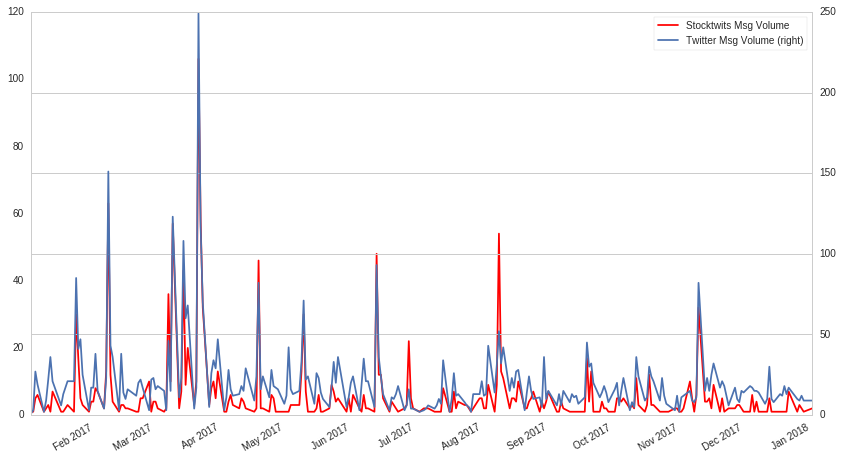

In [8]:
# Define technicals output dataframe
tdg_technical_output = technicals_output.xs(asset,level=1)
#tdg_technical_output.plot(subplots=True);

# Plot message volume to compare between Stocktwits and Twitter Datasets
tdg_technical_output.msg_volume_stocktwits.plot(label='Stocktwits Msg Volume', legend=True, color='Red')
tdg_technical_output.msg_volume_twitter.plot(secondary_y=True, label="Twitter Msg Volume", legend=True)

# Get Pearson Correlation Coefficient
x = tdg_technical_output.msg_volume_stocktwits.values.ravel()
y = tdg_technical_output.msg_volume_twitter.values.ravel()
ppmcc = stats.pearsonr(x, y)

print "PPMCC is {}" .format(ppmcc[0])
print "P-Value is {}" .format(ppmcc[1])

PPMCC is 0.104469832932
P-Value is 0.097986810709


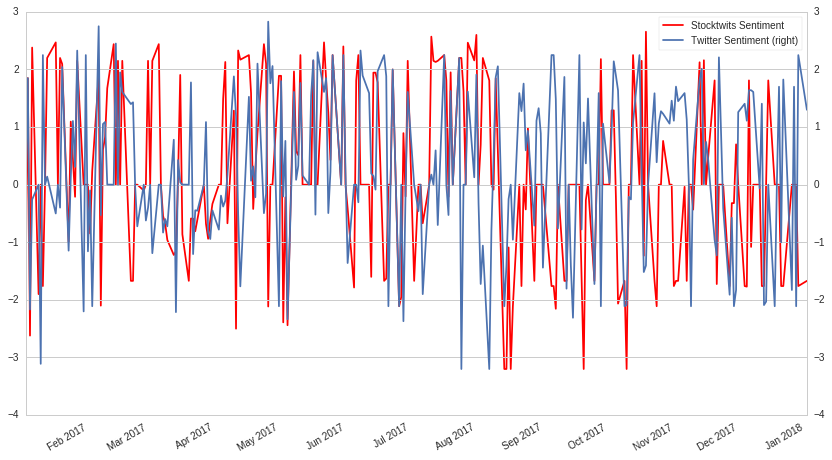

In [9]:
# Plot sentiment data to compare between Stocktwits and Twitter Datasets
tdg_technical_output.sentiment_stocktwits.plot(label='Stocktwits Sentiment', legend=True, color='Red')
tdg_technical_output.sentiment_twitter.plot(secondary_y=True, label="Twitter Sentiment", legend=True)

# Get Pearson Correlation Coefficient
x = tdg_technical_output.sentiment_stocktwits.values.ravel()
y = tdg_technical_output.sentiment_twitter.values.ravel()
ppmcc = stats.pearsonr(x, y)

print "PPMCC is {}" .format(ppmcc[0])
print "P-Value is {}" .format(ppmcc[1])

In [10]:
print tdg_technical_output.sentiment_stocktwits.mean()
print tdg_technical_output.sentiment_twitter.mean()

0.117214940476
0.265875861111


#### Takeaways
Based on the the case above, there is a correlation between message volume on both platforms, however there is also a large disparity between user sentiment. This may be due to the userbase demographic of either platform, or an underlying opinionated framework within the platform itself.

###Technical Data Correlation to Returns

In this section, we'll look for correlation between media sentiment/message volume, and daily returns. In order to do this, the data will be seperated into two categories - Daily Positive Returns, and Daily Negative Returns. This is done so that we can compare correllation between the datasets in a scalar way, and avoid negative values interfering with the PPMCC.

In [52]:
# Define normalization function - remap all values in a dataset between 0 and 1
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# Seperate DataFrames between Positive and Negative daily returns
positive_returns_table = normalize(tdg_technical_output.loc[tdg_technical_output['daily_returns'] > 0])
negative_returns_table = tdg_technical_output.loc[tdg_technical_output['daily_returns'] < 0]

# Take the absolute values of the Negative Returns table
negative_returns_table['daily_returns'] = negative_returns_table['daily_returns'].apply(np.abs)
negative_returns_table = normalize(negative_returns_table)

# Visualisation Options
#negative_returns_table.head()
#positive_returns_table.plot(subplots=True)
#negative_returns_table.plot(subplots=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


###Positive Returns Analysis

daily_returns Correlation to Returns is 1.0
msg_volume_stocktwits Correlation to Returns is 0.312813232653
msg_volume_twitter Correlation to Returns is 0.386471405291
sentiment_stocktwits Correlation to Returns is 0.0415202074749
sentiment_twitter Correlation to Returns is 0.0829274103429


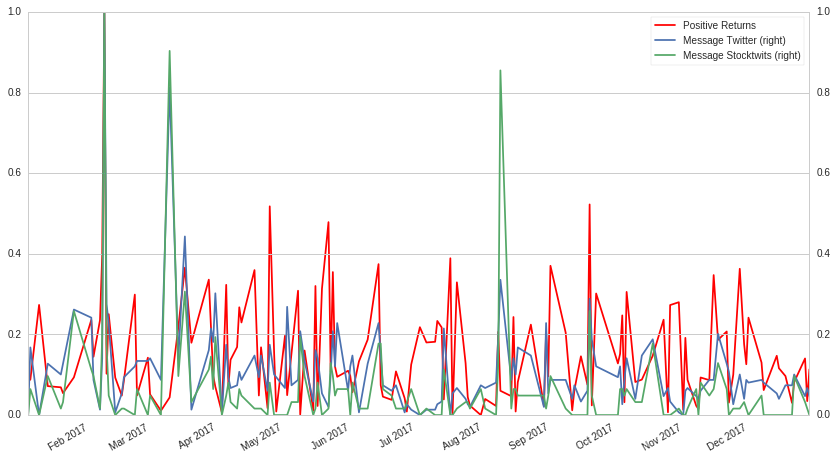

In [56]:
# Plot data
positive_returns_table.daily_returns.plot(label='Positive Returns', legend=True, color='Red')
positive_returns_table.msg_volume_twitter.plot(secondary_y=True, label="Message Twitter", legend=True)
positive_returns_table.msg_volume_stocktwits.plot(secondary_y=True, label="Message Stocktwits", legend=True)

# Get Pearson Correlation Coefficient
x = positive_returns_table.daily_returns.values.ravel()
for column in positive_returns_table:
    y = positive_returns_table[column].values.ravel()
    pmc = stats.pearsonr(x, y)
    print "{} Correlation to Returns is {}".format(column, pmc[0])

###Negative Returns Analysis

daily_returns Correlation to Returns is 1.0
msg_volume_stocktwits Correlation to Returns is 0.464431271171
msg_volume_twitter Correlation to Returns is 0.465448019461
sentiment_stocktwits Correlation to Returns is -0.179622272223
sentiment_twitter Correlation to Returns is -0.127577837667


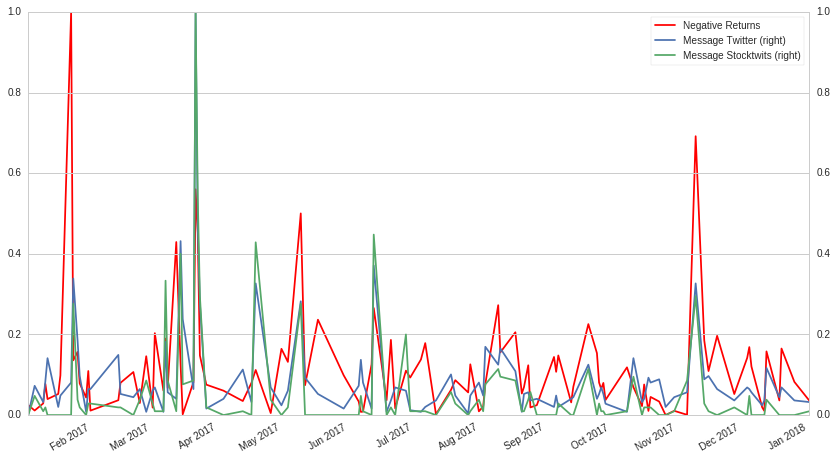

In [55]:
negative_returns_table.daily_returns.plot(label='Negative Returns', legend=True, color='Red')
negative_returns_table.msg_volume_twitter.plot(secondary_y=True, label="Message Twitter", legend=True)
negative_returns_table.msg_volume_stocktwits.plot(secondary_y=True, label="Message Stocktwits", legend=True)

# Get Pearson Correlation Coefficient
x = negative_returns_table.daily_returns.values.ravel()
for column in negative_returns_table:
    y = negative_returns_table[column].values.ravel()
    pmc = stats.pearsonr(x, y)
    print "{} Correlation to Returns is {}".format(column, pmc[0])

#### Takeaways
In this case, message volume is more strongly correlated to negative daily returns, rather than positive daily returns. Sentiment is found to have little to no correlation. This would suggest that media volume has a stronger negative effect, and that the specifics of the media message have little to no effect.

daily_returns Correlation to Returns is 1.0
msg_volume_stocktwits Correlation to Returns is 0.341726629789
msg_volume_twitter Correlation to Returns is 0.393080983824
sentiment_stocktwits Correlation to Returns is -0.0830906489794
sentiment_twitter Correlation to Returns is -0.176587071115


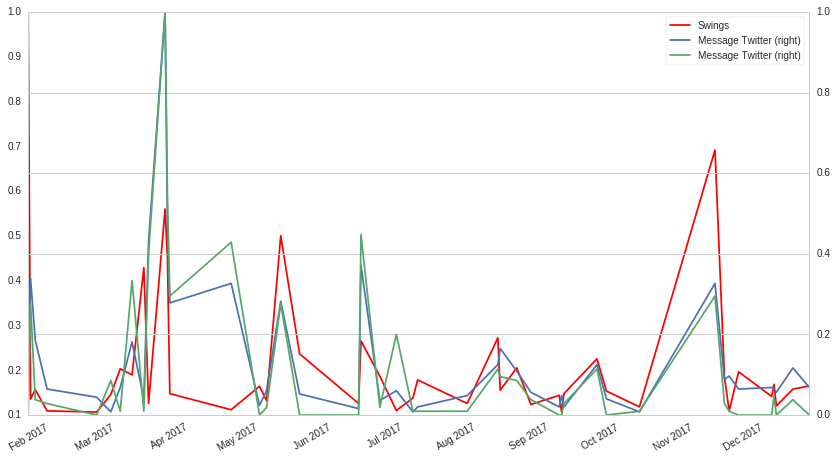

In [85]:
large_negative_swings = negative_returns_table.loc[negative_returns_table['daily_returns'] > 0.1]

large_negative_swings.daily_returns.plot(label='Swings', legend=True, color='Red')
large_negative_swings.msg_volume_twitter.plot(secondary_y=True, label="Message Twitter", legend=True)
large_negative_swings.msg_volume_stocktwits.plot(secondary_y=True, label="Message Twitter", legend=True)

# Get Pearson Correlation Coefficient
x = large_negative_swings.daily_returns.values.ravel()
for column in large_negative_swings:
    y = large_negative_swings[column].values.ravel()
    pmc = stats.pearsonr(x, y)
    print "{} Correlation to Returns is {}".format(column, pmc[0])

###Fundamentals

The analysis in this section is based on the following principles:
1. **Over-Valued** - Share Price grows faster than a company's valuation. Perhaps based on public opinion, political shifts, or other forms of speculation.
2. **Correctly-Valued** - Share Price correlates with a company's Enterprise Value.
3. **Under-Valued** - Share Price is [TBD]

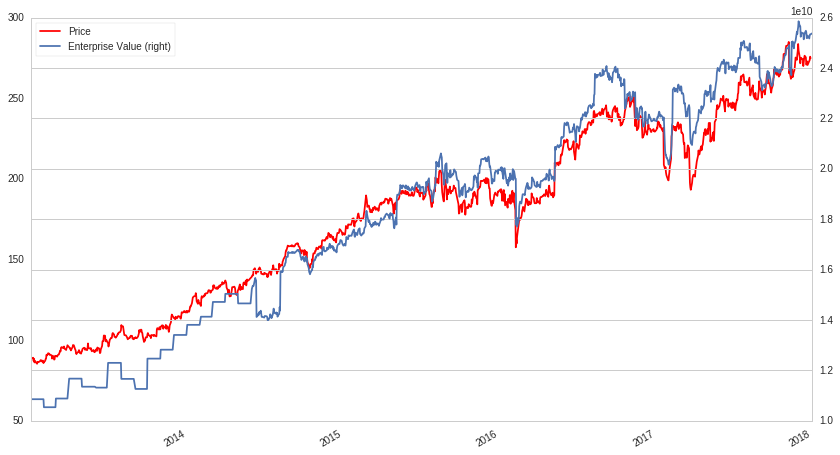

In [14]:
# Define fundamentals output dataframe
tdg_fundamentals_output = fundamentals_output.xs(asset,level=1)

# Plot pricing vs Enterprise Value to compare trends
tdg_pricing_dataframe.TDG.plot(label='Price', legend=True, color='Red')
tdg_fundamentals_output.enterprise_value.plot(secondary_y=True, label="Enterprise Value", legend=True)

In [15]:
x = tdg_pricing_dataframe.TDG
x = x.values.ravel()
y = tdg_fundamentals_output.enterprise_value
y = y.values.ravel()[:-1]

ppmcc = stats.pearsonr(x, y)
print "PPMCC is {}" .format(ppmcc[0])
print "P-Value is {}" .format(ppmcc[1])

PPMCC is 0.99056045307
P-Value is 0.0
